In [54]:
##### Importando Bibliotecas: #####
from sklearn.metrics import mean_squared_error
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from random import randint
from scipy import stats
import pandas as pd
import numpy as np
import itertools
import requests
import math
import re
import os

######## Funções: ########

# Calcula o valor previso para Y usando (testado e verificado)
def prevY_grau1(varX, coef):
    Ycalc, [b0,b1] = [], coef
    
    for xi in list(varX):
        yi_calc = b0 + b1*xi
        Ycalc.append(yi_calc)

    return Ycalc

#Recebe uma URL e retorna o código HTML da página (Só é chamada pela função baixarBD)
def baixarhtml(url):
    html = requests.get(url).text.splitlines()
    return html

def regressao(lX,lY):
    Xreg = sm.add_constant(lX)
    model = sm.OLS(lY,Xreg)
    results = model.fit()
    return results

#Plot gráfico de dispersão com pontos de lX e lY e traça a reta usando MMQ
#Testado e verificado
def graficoDispersaoReta(lX,lY):
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(lX, lY, 'ro')
    ax.plot(lX, Ycalc(lX,lY, mmq(lX,lY)))
    plt.show()

In [2]:
####################################################################
######## Funções que existem em bibliotecas mas que criei: ########

# RMS = Erro Quadrático Médio (Mean Squared Error) (testada)
# O mesmo que: math.sqrt(mean_squared_error(orig, pred)
def rms(orig, pred):
    n, soma = len(orig), 0
    
    for i in range(n):
        soma += (orig[i] - pred[i])**2
    
    valor = math.sqrt(soma/n)
    return valor


# MMQ = Método dos Mínimos Quadrados (Least squares) (testada)

def mmq(lX,lY):
    mediaX, mediaY = np.mean(lX), np.mean(lY)

    Sxx, Sxy = 0, 0
    for num in range(len(lX)):
        deltaX, deltaY = (lX[num] - mediaX), (lY[num] - mediaY)
        Sxx += deltaX **2
        Sxy += deltaX * deltaY

        b1 = Sxy/Sxx
        b0 = mediaY - b1*mediaX

    return [b0,b1]

___
# Ciência dos Dados - PROJETO 3 - INSPER

___
### Mariana Abrantes, Gabriel Couto e Gabriel Miras
___

# Previsão do preço do Iphone X através do preço do dolar e de outros 7 smartphones do mercado

___

## A. INTRODUÇÃO

Nestes últimos anos, com a instabilidade política e socioeconômica do Brasil, o preço do dólar está em constante variação. Consequentemente, os valores sobre produtos estrangeiros também mudam. Além disso, o preço de outros dispositivos do mercado podem influenciar o preço de um produto. Ao visualizar esse cenário, gostaríamos de analisar a influência da alteração do valor do dólar, de 3 aparelhos da Apple e de 4 aparelhos da Samsung sobre o preço do Iphone X.

Escolhemos criar modelos preditivos usando 7 modelos de smarthphones disponíveis no mercado e o preço do dólar para fazermos previsões a cerca do preço do Iphone X.<br>
<br>
__Variável Dependente (resposta) - Y : Preço do Iphone X__ (Váriavel de interesse cujo comportamento se deseja explicar)<br>
__Variável Independente (explicativa) - X: Dolar e o preço dos outros celulares__ (Usadas para explicar Y)<br>

___
## B. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

___
### B.1) Minerando Dados

__I) Preço do Dólar__ <br>
&emsp;O DataFrame foi obtido no [site](https://economia.uol.com.br/cotacoes/cambio/dolar-comercial-estados-unidos/) através do [link](https://api.cotacoes.uol.com/currency/interday/list/years/?format=JSON&fields=askvalue,date&currency=1) em JSON e foi filtrado da seguinte forma:
 * a) Definimos a coluna 'Data' como índice da tabela
 * b) Pegamos apenas a coluna 'Compra' com o preço do dolar no dia e o índice das linhas
 * c) Definimos a coluna 'Compra' do tipo float e renomeamos ela pra "Dolar"

In [3]:
codeDolar = baixarhtml('https://api.cotacoes.uol.com/currency/interday/list/years/?format=JSON&fields=askvalue,date&currency=1')
bdDolar = codeDolar[0].split('"docs":')[1][:-1]
bdDolar = re.sub('000000"}'  ,'"}', bdDolar)
dfDolar = pd.read_json(bdDolar)
dfDolar.columns = ['Dolar','Data']
dfDolar['Data'] = pd.to_datetime(dfDolar['Data'],  format='%Y%m%d')
dfDolar.index = dfDolar['Data']
dolar = dfDolar[['Dolar']]

__II) Tabela de Preços dos Smartphones__ <br>
Os dados de cada celular foram retirados do histórico de preço médio do site buscape. <br>
* a) A função gerarBD() recebe uma lista com nome e url do celular para retornar um Dataframe de preço dos celulares e do dolar por dia.<br>
Para cada linha da lista:
    * 1) Cria uma cópia do Dataframe dolar chamado table
    * 2) Baixa o código da url fornecida e captura o ID do produto
    * 3) Com o ID baixamos o histórico de preço médio do aparelho em JSON e criamos o Dataframe bd com ele
    * 4) Usamos .join para unir as colunas num novo dataframe
    * 5) Definimos a coluna 'Data' como do tipo datetime e em seguida definimos essa coluna como índice da tabela<br>
* b) Removemos as linhas que possuam ao menos um valor vazio e retornamos essa nova tabela como resultado da função

In [4]:
#Recebe url do Buscape e retorna um Dataframe 
def gerarBD(lista):
    table = dolar.copy()
    
    for num in range(len(lista)):
        produto, url = lista[num][0], lista[num][1]
        
        #Pega ID do produto do buscape usando a url fornecida
        code = baixarhtml(url)
        for num_linha in range(len(code)):
            match = re.findall('"productId":[0-9]*', code[num_linha])
            if len(match)>0:
                id = match[0].split(':')[1]

        #Baixa BD dos preços
        code = baixarhtml("https://www.buscape.com.br/async/history/idu/" + id + "/days/365")

        #Pega só a parte dos dados e cria tabela bd
        bd = pd.read_json(code[0].split('"historicos":')[1][:-1])

        #Converte data pro formato e define essa coluna como índice
        bd['data'] = pd.to_datetime(bd['data'],  format='%d/%m/%Y')
        bd.set_index(bd['data'], inplace=True)
        
        #Adiciona a coluna com o nome do produto o preço do produto
        table[produto] = bd.loc[:,['precomed']]
        table[produto] = table[produto].astype(float)
    
    table = table.dropna(how='any') # Tira linha que tiver algum valor NaN
    return table

#Função retorno
def func_retorno(n,n_ant):
    val = 0
    if n_ant == 0:
        print('tem zero')
    else:
        val = math.log(n/n_ant)
    return val

In [5]:
links = [
    ['Iphone X',          "https://www.buscape.com.br/smartphone-apple-iphone-x-64gb"],
    ['Iphone 8 Plus',     "https://www.buscape.com.br/smartphone-apple-iphone-8-plus-64gb"],
    ['Iphone 7',          "https://www.buscape.com.br/smartphone-apple-iphone-7-32gb"],
    ['Iphone 7 Plus',     "https://www.buscape.com.br/smartphone-apple-iphone-7-plus-128gb"],
    ['Galaxy S8',         "https://www.buscape.com.br/smartphone-samsung-galaxy-s8-sm-g950-64gb"],
    ['Galaxy S8 Plus',    "https://www.buscape.com.br/smartphone-samsung-galaxy-s8-plus-sm-g955-128gb"],
    ['Galaxy S9',         "https://www.buscape.com.br/smartphone-samsung-galaxy-s9-sm-g960-128gb"],
    ['Galaxy S9 Plus',    "https://www.buscape.com.br/smartphone-samsung-galaxy-s9-plus-sm-g965-128gb"]
]

___
### B.2) Características do Dataset

O dataset reune os preços diarios dos aparelhos durante um período de 6 meses, além de nos dar a informação de seus preços médios, preço mais baixo e preço mais elevado.

___
__Salvando os dados para não precisar criar um dataframe a cada execução do código__<br>
Se não houver o arquivo tabela.csv na pasta executa a função gerarBD() e salva o dataframe como tabela.csv, se já houver o arquivo tabela.csv carrega ele como tabela.

In [6]:
#Se já tiver um arquivo tabela.csv salvo carrega ele, se não cria a tabela e salva ela
exists = os.path.isfile('tabela.csv')
if exists:
    tabela = pd.read_csv('tabela.csv', sep=",")
    tabela.index = tabela['data']
    tabela = tabela.loc[:,list(tabela.columns)[1:]]
else:
    tabela = gerarBD(links)
    tabela.to_csv('tabela.csv')

### BASE DE DADOS

__I)Tabela com todos dados que serão usados:__<br>

In [7]:
tabela.head(3)

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
data,,,,,,,,,
2018-05-22,5791.4575,4019.5854,3033.4468,3491.2202,3050.4950,4085.785,3956.2925,4479.7305,3.6447
2018-05-23,5853.7800,4057.0140,3043.2737,3406.8965,3061.1514,3672.570,3966.1755,4490.3880,3.6251
2018-05-24,5885.4900,3896.7625,2852.5547,3444.2380,2992.7668,4028.438,3966.7402,4502.2856,3.6483


__II) Criando tabela de retorno__ <br>

In [8]:
df = tabela.copy()

#Cria coluna com o valor da linha anterior
for coluna in tabela.columns:
    df[coluna+'-1'] = df[coluna].shift(1)

df = df.iloc[1:,:] # Tira primeira linha (perdida pra fazer deltas)

dic={}
for coluna in tabela.columns:
    lis,ind=[],[]
    for index, row in df.iterrows():
        retor = func_retorno(row[coluna],row[coluna+'-1'])
        lis.append(retor)
        ind.append(index)
    dic[coluna]=lis

retorno = pd.DataFrame(data=dic,index=ind)

In [9]:
retorno.head(3)

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
2018-05-23,0.010704,0.009268,0.003234,-0.024450,0.003487,-0.106622,0.002495,0.002376,-0.005392
2018-05-24,0.005402,-0.040301,-0.064719,0.010901,-0.022593,0.092487,0.000142,0.002646,0.006379
2018-05-25,-0.001517,0.031066,0.045622,0.007526,0.044937,-0.088895,0.010331,-0.007334,0.005467


__III) Separando a tabela em teste e treinamento__

In [10]:
percentTreino = 0.8 #Proporção entre o comprimento do treinamento o dataframe dados.

treino = retorno.sample(frac=percentTreino,random_state=randint(0,100000))
teste = retorno.drop(treino.index)

print('Comprimento Teste: '+str(len(teste))+' | Comprimento Treino: '+str(len(treino)))

Comprimento Teste: 49 | Comprimento Treino: 195


Definindo algumas variáveis que serão usadas:

In [11]:
# colRes = Coluna Resposta (Dependente)
colRes = 'Iphone X'

# colExp = Lista de Colunas Explicativas (Independentes)
colExp = list(treino.columns)
colExp.remove(colRes)

# dataframe Resposta 
dfRes = treino.loc[:,[colRes]]

# dataframe variáveis Explicativas 
dfExp = treino.loc[:,colExp]

### ANÁLISE DESCRITIVA

Em nossa base de dados buscamos os preços de telefones das marcas Apple e Samsung, sendo eles Iphone X, Iphone 8 Plus, Iphone 7 plus, iphone 7, Galaxy S8, Galaxy S8 Plus, Galaxy S9 e Galaxy S9 Plus.

In [12]:
#Correlação
retorno.corr()

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
Iphone X,1.000000,0.077340,0.153120,0.150596,0.074914,0.057238,0.153962,0.105623,-0.000626
Iphone 8 Plus,0.077340,1.000000,0.134727,0.199152,0.086202,-0.018669,0.091178,0.017414,-0.014322
Iphone 7,0.153120,0.134727,1.000000,0.377102,-0.063667,-0.016796,-0.120391,-0.001215,-0.045196
Iphone 7 Plus,0.150596,0.199152,0.377102,1.000000,0.007376,-0.022155,-0.021023,-0.040070,0.079599
Galaxy S8,0.074914,0.086202,-0.063667,0.007376,1.000000,-0.063318,0.143817,0.146873,-0.078579
Galaxy S8 Plus,0.057238,-0.018669,-0.016796,-0.022155,-0.063318,1.000000,-0.123022,-0.115546,-0.039319
Galaxy S9,0.153962,0.091178,-0.120391,-0.021023,0.143817,-0.123022,1.000000,0.319579,0.049093
Galaxy S9 Plus,0.105623,0.017414,-0.001215,-0.040070,0.146873,-0.115546,0.319579,1.000000,0.032512
Dolar,-0.000626,-0.014322,-0.045196,0.079599,-0.078579,-0.039319,0.049093,0.032512,1.000000


# Descriçao analise 

In [13]:
treino.describe()

,Iphone X,Iphone 8 Plus,Iphone 7,Iphone 7 Plus,Galaxy S8,Galaxy S8 Plus,Galaxy S9,Galaxy S9 Plus,Dolar
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000
mean,-0.000710,0.000693,0.000282,0.001830,0.000693,-0.001924,-0.002746,-0.001200,0.000038
std,0.027698,0.034735,0.036494,0.037320,0.033392,0.037291,0.043892,0.036075,0.010439
min,-0.105792,-0.124957,-0.133576,-0.125220,-0.125202,-0.220123,-0.287738,-0.113739,-0.057482
25%,-0.009141,-0.011601,-0.017368,-0.010028,-0.012746,-0.005896,-0.015958,-0.021719,-0.006751
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000564
75%,0.007919,0.014821,0.013966,0.012962,0.011465,0.000000,0.017326,0.015299,0.006363
max,0.139597,0.116284,0.108913,0.155254,0.142910,0.232399,0.149577,0.112801,0.026513


__I) Análise Univariada:__ <br>

Histograma das variáveis:

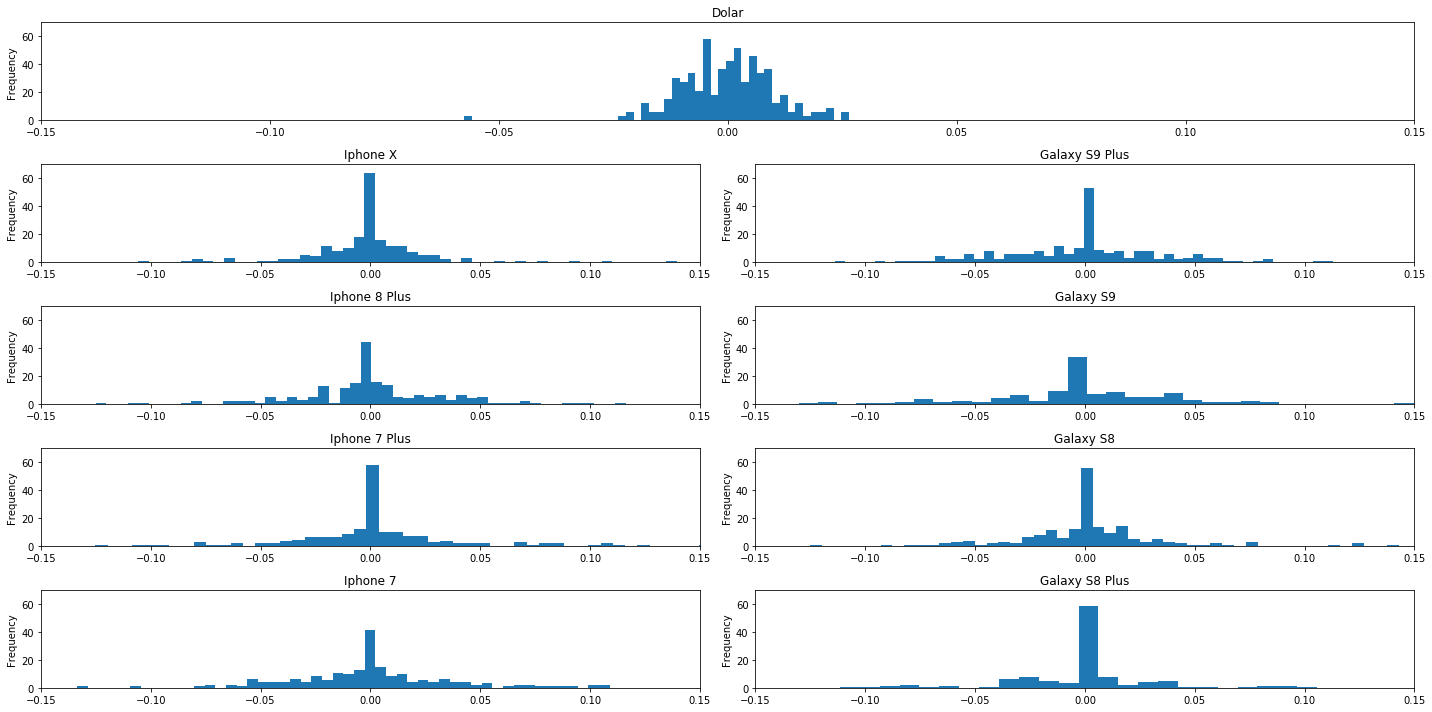

In [14]:
#Limites do gráfico:
xlim, ylim = [-0.15,0.15], [0,70] 

#Dita a ordem que os grpaficos vão aparecer
labels0 = ['Iphone X','Iphone 8 Plus','Iphone 7 Plus','Iphone 7']
labels1 = ['Galaxy S9 Plus', 'Galaxy S9', 'Galaxy S8', 'Galaxy S8 Plus']
labels = [labels0, labels1]

fig = plt.figure(figsize=(20,10)) #largura da linha,altura da linha

#Dolar
plt.subplot2grid((5, 2), (0, 0), colspan=2)
plt.xlim(xlim[0],xlim[1])
plt.ylim(ylim[0],ylim[1])
treino['Dolar'].plot.hist(bins=50, title='Dolar', density=True);        

#Outras colunas
for n_y in [0,1]:
    for n_x in [1,2,3,4]:
        ax = plt.subplot2grid((5, 2), (n_x, n_y))
        plt.xlim(xlim[0],xlim[1])
        plt.ylim(ylim[0],ylim[1])
        treino[labels[n_y][n_x-1]].plot.hist(bins=50, title=labels[n_y][n_x-1], density=True);        
        
plt.tight_layout()
plt.show()

___
## C. MODELOS DE PREDIÇÃO

In [15]:
Xn= range(len(dfRes))
Y = dfRes[colRes]

### C.1) Modelo de Predição pela Média (Sem uso de variável explicativa).
Consiste em usarmos como equação matemática do modelo à reta paralela ao eixo X da forma: $$y(x) = \mu$$ Sendo $\mu$ a média aritmética dos valores da variável resposta.

In [16]:
mediaY = np.mean(Y)
yPred = [mediaY] * len(Y)
print('Média (μ) = ' + "{:.8f}".format(mediaY))

Média (μ) = -0.00071013


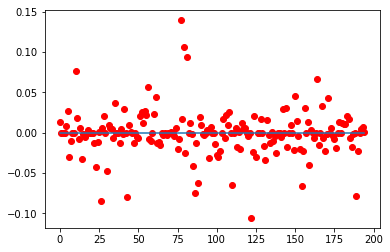

In [17]:
fig = plt.figure()
ax = plt.axes()
ax.plot(Xn, Y, 'ro')
ax.plot(Xn, yPred)
plt.show()

__Conferindo eficiência:__

In [18]:
print('RMS:',"{:.8f}".format(rms(Y,yPred)))

RMS: 0.02762734


### C.2) Modelo de Regressão Linear Múltipla (Multiple Linear Regression)__
$$\hat{y}(t)=\beta_{0}+ \beta_{1}x_{1}+ \beta_{2}x_{2} + \cdots + \beta_{8}x_{8}+ \epsilon_{i}$$
Em que $\beta_{i}$ é o coeficiente, $\epsilon_{i}$ é o erro aleatório da medida i, $\hat{y}(t)$ é o valor de y previsto no 'instante' i.

In [19]:
results = regressao(dfExp,dfRes)
Ypred = results.predict()
Yp = pd.Series(Ypred, index=Y.index)

print('RMS:', rms(Y,Yp))
results.summary()

RMS: 0.02628249399530095


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Iphone X   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     2.440
Date:                Sun, 26 May 2019   Prob (F-statistic):             0.0156
Time:                        10:08:24   Log-Likelihood:                 432.88
No. Observations:                 195   AIC:                            -847.8
Df Residuals:                     186   BIC:                            -818.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0005      0.002     -0.275      0.783      -0.004       0.003
Iphone 8 Plus      0.0441      0.058      0.765      0.445      -0.070       0.158
Iphone 7           0.1533      0.057      2.674      0.008       0.040       0.266
Iphone 7 Plus      0.0519      0.057      0.917      0.360      -0.060       0.163
Galaxy S8          0.0570      0.060      0.954      0.341      -0.061       0.175
Galaxy S8 Plus     0.0496      0.053      0.936      0.350      -0.055       0.154
Galaxy S9          0.0663      0.048      1.381      0.169      -0.028       0.161
Galaxy S9 Plus     0.0891      0.057      1.551      0.123      -0.024       0.203
Dolar             -0.0180      0.188     -0.095      0.924      -0.390       0.354
==============================================================================
Omnibus:                       30.765   Durbin-Watson:                   1.874
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.942
Skew:                           0.095   Prob(JB):                     8.66e-50
Kurtosis:                       8.270   Cond. No.                         98.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

* Como nosso R² ajustado (Adj-R-squared) é muito baixo esse modelo não consegue explicar com eficiência a variabilidade dos dados.
* Como __Prob(Omnibus)__ é zero e __Prob(JB)__ tende à zero, há grande evidência que os resíduos não são distribuídos de forma normal, violando a suposição do modelo de regressão.
* O __Durbin-Watson__ próximo de 2 sugere que não há autocorrelação dos resíduos

__Os coeficientes beta:__<br>

In [20]:
results.params

const            -0.000533
Iphone 8 Plus     0.044102
Iphone 7          0.153339
Iphone 7 Plus     0.051881
Galaxy S8         0.057039
Galaxy S8 Plus    0.049590
Galaxy S9         0.066273
Galaxy S9 Plus    0.089150
Dolar            -0.017993
dtype: float64

__Verificando a normalidade dos resíduos ($e$):__ $e_i=y_i-\hat{y}_i$

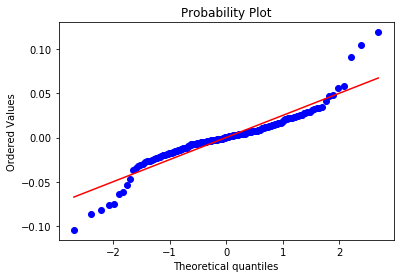

In [21]:
stats.probplot(results.resid, dist='norm', plot=plt); # Verifique graficamente  se é uma normal - como fazer isso?

__Conferindo eficiência:__

In [22]:
Yprev = results.predict()
print('RMS:', rms(Y,Yprev))

RMS: 0.02628249399530095


### C.3) Modelo dos K Vizinhos Mais Próximos (K-Nearest Neighbors Regression)
o MODELO DOS K VIZINHOS MAIS PRÓXIMOS

In [47]:
#from sklearn.model_selection import train_test_split  
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

In [48]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(colExp)

x_train = scaler.transform(colExp)  
x_test = scaler.transform(x_test)

In [60]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors = 2)  
classifier.fit(colExp, colRes)

ValueError: Expected 2D array, got 1D array instead:
array=['Iphone 8 Plus' 'Iphone 7' 'Iphone 7 Plus' 'Galaxy S8' 'Galaxy S8 Plus'
 'Galaxy S9' 'Galaxy S9 Plus' 'Dolar'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [51]:
y_pred = classifier.predict(x_test)

NotFittedError: This KNeighborsClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

In [52]:
from sklearn.metrics import classification_report, confusion_matrix  
print(confusion_matrix(y_test, y_pred))  
print(classification_report(y_test, y_pred))

NameError: name 'y_pred' is not defined

In [53]:
classifier = KNeighborsClassifier(n_neighbors = 9)
classifier.fit(x_train, y_train)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

ValueError: Unknown label type: 'continuous'

### C.4) Modelo de Árvores de Regressão (Decision Tree Regression)
o MODELO DE ÁRVORES DE REGRESSÃO 

In [57]:
#Importa biblioteca
#Importa outras bibliotecas necessárias como pandas, numpy...
from sklearn import tree
#Assume que você tem X (preditor) e Y (alvo) para dados de treino e x_test(predictor) dos dados de teste
# Cria o objeto tree
model = tree.DecisionTreeClassifier(criterion='gini') 
# Para classificação, aqui você pode mudar o algoritmo para gini ou para entropy (Ganho de informação). Por default é gini  
# model = tree.DecisionTreeRegressor() para regressão
# Treina o modelo usando os dados de treino e de teste confere o score
model.fit(X, y)
model.score(X, y)
#Prevê o resultado
predicted= model.predict(x_test)

NameError: name 'X' is not defined

In [ ]:
# Importing the Library 
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

# Importing the dataset
dataset= pd.read_csv('Data.csv')
X = dataset.iloc[: , 1:2].values
Y = dataset.iloc[: , 2].values

# Fitting Simple Linear Regression model to the data set
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(random_state = 0)
regressor.fit(X, y)

# Predicting a new result
y_pred = regressor.predict(6.5)

# Visualising the Decision Tree Regression results

X_grid = np.arange(min(X), max(X), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X, regressor.predict(X_grid), color = 'blue')
plt.title('Truth or Bluff (Decision Tree Regression)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()
view rawDT2.py hosted with ❤ by GitHub

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

[Esse item depende dos resultados das modelagens anteriores! Organize-os aqui de forma clara!]

___
## E. CONCLUSÃO

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS

https://br.investing.com/ $\rightarrow$ site para busca da cotação dos dolores
_________
https://www.buscape.com.br $\rightarrow$ site para busca de histórico dos preços